# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


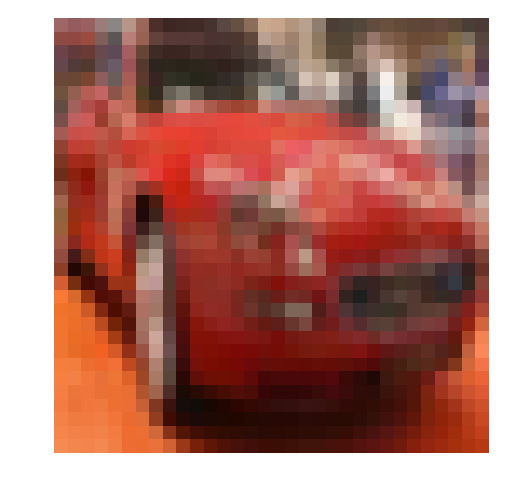

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize

In [3]:
#### normalization 
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    x_min = np.min(x)
    x_max = np.max(x)
    x_norm = (x+x_min)/(x_min+x_max)
    return x_norm

    ### why not perform mean/std normalization, so that data will be aournd 0 ??? isn't that better ?

#### One hot encoding 
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    n = np.max(x)     # start from 0 
    size = len(x)     # start from 0 
    one_hot = np.zeros((size,n+1))
    one_hot[np.arange(size),x]=1
    return one_hot

# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [5]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    h,w,d = image_shape
    shape = [None,h,w,d]
    x = tf.placeholder(tf.float32,shape,name="x")
    return x

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    y = tf.placeholder(tf.float32,[None,n_classes],name= "y")
    return y

def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    keep_prob = tf.placeholder(tf.float32,name="keep_prob")
    return keep_prob


### Convolution and Max Pooling Layer

In [6]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    filters = conv_num_outputs
    d = x_tensor.get_shape().as_list()[-1]
    h,w = conv_ksize
    s_h,s_w = conv_strides
    b = tf.Variable(tf.random_normal([filters]))

    ## conv process
    W = tf.Variable(tf.truncated_normal([h,w,d,filters],stddev=1/tf.sqrt(float(conv_num_outputs)))) 
    x_tensor = tf.nn.conv2d(x_tensor,W,strides=[1,s_h,s_w,1],padding='SAME')
    x_tensor = tf.nn.bias_add(x_tensor, b)
    x_tensor = tf.nn.relu(x_tensor)
    
    ## max pool process
    k_h, k_w = pool_ksize
    ks_h,ks_w = pool_strides
    x_tensor = tf.nn.max_pool(x_tensor,
        ksize = [1,k_h,k_w,1],      ## k is the size of the filter 
        strides=[1,ks_h,ks_w,1],
        padding='SAME'
    )
    return x_tensor 

### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [7]:
#### flatten layer 
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    shape = x_tensor.get_shape().as_list()
    row_length = shape[1]*shape[2]*shape[3]          ## calculate image length 
    x_tensor = tf.reshape(x_tensor,[-1,row_length])
    return x_tensor

#### fully connected layer
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    n = x_tensor.get_shape().as_list()[1]              ## get the number of columns
    W = tf.Variable(tf.truncated_normal([n,num_outputs],stddev=1/tf.sqrt(float(num_outputs))) )
    b = tf.Variable(tf.random_normal([num_outputs]))
    x_tensor = tf.add(tf.matmul(x_tensor,W),b)
    x_tensor = tf.nn.relu(x_tensor)
    return x_tensor

#### output layer 
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    n = x_tensor.get_shape().as_list()[1]              ## get the number of columns
    W = tf.Variable(tf.truncated_normal([n,num_outputs],stddev=1/tf.sqrt(float(num_outputs))) )
    b = tf.Variable(tf.random_normal([num_outputs]))
    x_tensor = tf.add(tf.matmul(x_tensor,W),b)
    return x_tensor


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

In [8]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    l1 = conv2d_maxpool(x, 16, (3,3), (1,1), (2,2), (2,2))
    l2 = conv2d_maxpool(l1, 32, (3,3), (1,1), (2,2), (2,2))
    l3 = conv2d_maxpool(l2, 64, (3,3), (1,1), (2,2), (2,2))

    #   flatten(x_tensor)
    fl1 = flatten(l3)

    #   fully_conn(x_tensor, num_outputs)
    fc1 = fully_conn(fl1, 256)
    fc1 = tf.nn.dropout(fc1,keep_prob)
    fc2 = fully_conn(fc1, 128)
    fc2 = tf.nn.dropout(fc2,keep_prob)

    #   output(x_tensor, num_outputs)
    out = output(fc2,10)
    
    # TODO: return output
    return out



##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)

keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



Neural Network Built!


## Train the Neural Network
### Single Optimization

In [9]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer,feed_dict={
        x:feature_batch,
        y:label_batch,
        keep_prob:keep_probability
    })
    pass


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [10]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss = sess.run(cost, feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))
    pass

### Hyperparameters

In [12]:
# TODO: Tune Parameters
epochs = 30
batch_size = 256*2
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch - try overfitting the data

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.5170 Validation Accuracy: 0.125000
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.2962 Validation Accuracy: 0.148649
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.2772 Validation Accuracy: 0.165541
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.3363 Validation Accuracy: 0.138514
Epoch  5, CIFAR-10 Batch 1:  Loss:     2.3025 Validation Accuracy: 0.145270
Epoch  6, CIFAR-10 Batch 1:  Loss:     2.2601 Validation Accuracy: 0.172297
Epoch  7, CIFAR-10 Batch 1:  Loss:     2.2732 Validation Accuracy: 0.162162
Epoch  8, CIFAR-10 Batch 1:  Loss:     2.2350 Validation Accuracy: 0.158784
Epoch  9, CIFAR-10 Batch 1:  Loss:     2.2394 Validation Accuracy: 0.162162
Epoch 10, CIFAR-10 Batch 1:  Loss:     2.1958 Validation Accuracy: 0.182432
Epoch 11, CIFAR-10 Batch 1:  Loss:     2.1915 Validation Accuracy: 0.175676
Epoch 12, CIFAR-10 Batch 1:  Loss:     2.1431 Validation Accuracy: 0.172297
Epoch 13, CIFAR-10 Batch 1:  Loss:     2.1255

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.2726 Validation Accuracy: 0.172297
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.9762 Validation Accuracy: 0.293919
Epoch  3, CIFAR-10 Batch 5:  Loss:     1.7954 Validation Accuracy: 0.347973
Epoch  4, CIFAR-10 Batch 5:  Loss:     1.6837 Validation Accuracy: 0.378378
Epoch  5, CIFAR-10 Batch 5:  Loss:     1.6004 Validation Accuracy: 0.375000
Epoch  6, CIFAR-10 Batch 5:  Loss:     1.5360 Validation Accuracy: 0.412162
Epoch  7, CIFAR-10 Batch 5:  Loss:     1.4731 Validation Accuracy: 0.449324
Epoch  8, CIFAR-10 Batch 5:  Loss:     1.4143 Validation Accuracy: 0.466216
Epoch  9, CIFAR-10 Batch 5:  Loss:     1.3577 Validation Accuracy: 0.500000
Epoch 10, CIFAR-10 Batch 5:  Loss:     1.2968 Validation Accuracy: 0.533784
Epoch 11, CIFAR-10 Batch 5:  Loss:     1.2718 Validation Accuracy: 0.530405
Epoch 12, CIFAR-10 Batch 5:  Loss:     1.2423 Validation Accuracy: 0.537162
Epoch 13, CIFAR-10 Batch 5:  Loss:     1.2012 Validation Accuracy: 0.547297


# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.6330939799547195



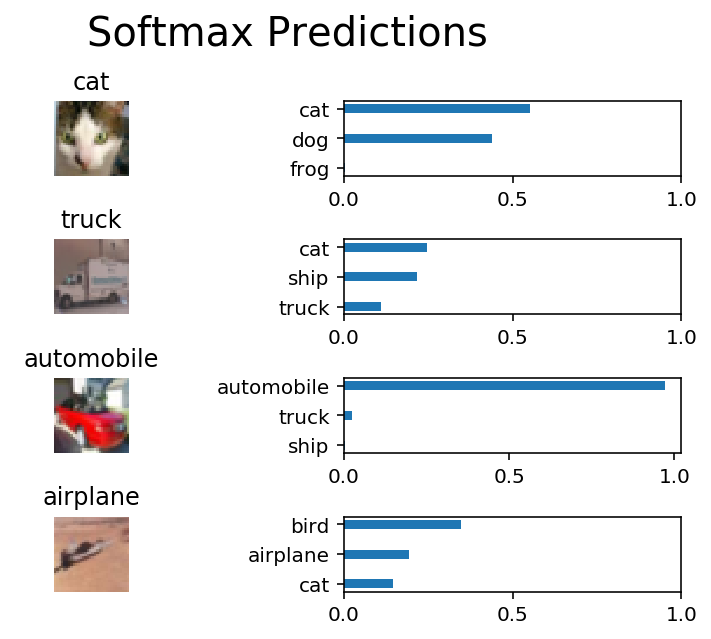

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.